In [9]:
import cv2
import pickle
import warnings
import numpy as np

from matplotlib import pyplot as plt

# other configurations
warnings.filterwarnings('ignore')
#plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [50, 50]


In [69]:
def plot(img):
    plt.figure()
    plt.grid(False)
    plt.imshow(img);

# getting the dashed and dotted lines, but the outputs have noises    
def dot_to_fullLines(img): 
    
    def noise(img,filter):
        def TrouveContours(image):
            ret, thresh_binary = cv2.threshold(image, 107, 255, cv2.THRESH_BINARY)
            
            # findcontours
            contours, hierarchy = cv2.findContours(
                image=thresh_binary, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
            return contours, hierarchy
            
        # checking if the image is in grayscale format
        if len(img.shape) == 3: 
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            pass

        kernel = np.ones((5,5),np.uint8)
        cell1 = cv2.dilate(img,  np.ones((5,5), np.uint8), 8)
        cell1 = cv2.morphologyEx(cell1, cv2.MORPH_OPEN, kernel)
        
        
        # create an empty mask
        cell1_cont = np.zeros(cell1.shape[:2], dtype=np.uint8)
        
        contours, hierarchy = TrouveContours(cell1) # the function which get the contrours of the image 
        
        # loop through the contours
        for i, cnt in enumerate(contours):
            # if the contour has no other contours inside of it
            if hierarchy[0][i][2] == -1:
                # if the size of the contour is greater or less than a threshold
                if cv2.contourArea(cnt) > filter:  # Dotted lines
                    cv2.drawContours(cell1_cont, [cnt], -1, (255),6, cv2.LINE_AA)
        
        # Getting only dotted lines from the gray dilated image
        full_lines = cv2.bitwise_and(cell1,cell1_cont)
        return full_lines

    I = img.copy()
    
    make_solid_lines = noise(I,filter=85)
    clear_img = noise(make_solid_lines,filter=250)
        
    return make_solid_lines

def line_detection(img):
    
    def rgb(x):
        x = int(x)
        while (x > 255):
            x-=255
        return x

    lines_list =[]

    # checking if the image is in grayscale format
    if len(img.shape) == 3: 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        image_all =  img.copy()
    else:
        gray = img.copy()
        image_all = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

    # Find the edges of features
    edges = cv2.Canny(gray,50,150,apertureSize=3)

    lines = cv2.HoughLinesP(
            edges, # Input edge image
            5, # Distance resolution in pixels
            np.pi / 180, # Angle resolution in radians
            150, # Min number of votes for valid line
            np.array([]), 
            minLineLength = 90, # Min allowed length of line
            maxLineGap = 40 # Max allowed gap between line for joining them
            )

    # Iterate over points
    for points in lines:
        # Extracted points nested in the list
        x1,y1,x2,y2=points[0]
        # Draw the lines joing the points On the original image
        
        # choosing the line color
        r = rgb(x1)
        g = rgb(y1)
        b = rgb(x2) 

        cv2.line(image_all,(x1,y1),(x2,y2),(r,g,b),4) # 0,100,255
        # Maintain a simples lookup list for points
        lines_list.append([x1,y1,x2,y2])

    '''
    # Removing small dotted on the image
    low = np.array([0, 80, 255])

    high = np.array([0,100, 255])

    mask = cv2.inRange(image_all, low, high)

    result = cv2.bitwise_and(image_all, 
             image_all, mask=mask)
    '''

    return image_all, lines_list, lines


def hadle_img(image, patches_lines, rgb1, flag):
        nx = 0
        rgb2 = (255,0,255)
        for v in patches_lines:
            n = str(nx)
            a,b,c,d = v.reshape(4)
            cv2.line(image, (a,b), (c,d), rgb1 , 5, cv2.LINE_AA)
            # check if is necessary to plot the key points on the image
            if flag == True:
                cv2.putText(image, n, (a,b), cv2.FONT_HERSHEY_SIMPLEX, 1, rgb2, 2, cv2.LINE_AA)
            else:
                pass
            nx += 1
        return image

def put_remove_seg(path, input_img, lists, dicts, flag):

    def rgb(x):
        x = int(x)
        if x <= 255:
            return x
        else:
            while (x > 255):
                x-=255
            return x

    copy_img = input_img.copy()
    # check the code'll have to use dictionary or list
    if dicts == None:
        rgb1 = (0,125,255)       
        patches_lines = lists.copy()
        intern_img = hadle_img(copy_img, patches_lines, rgb1, flag )
        cv2.imwrite(path + '/output/keypoints.png', intern_img)
        
    else:
        intern_img = copy_img
        get_lines = dicts.copy()

        for k in range(len(get_lines)):    
            key = k + 1      
            patches_lines = get_lines.get(key)
            
            try:
                r, g, b, _ = patches_lines[0].reshape(4)
            except IndexError:
                pass
            
            #choosing the line color
            r = rgb(r)
            g = rgb(g)
            b = rgb(b)
            rgb1 = (r, g, b)
            
            patches_lines = get_lines[key]
            intern_img = hadle_img(intern_img, patches_lines, rgb1, flag )  
           
        cv2.imwrite(path + '/output/final.png', intern_img)
    return intern_img  

In [3]:
I =  cv2.imread('out_dotted.jpg')
gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)


path = '/home/jacques/Documents/IC/lines_detection'

# Detect the lines on the image
image_lines, lines_detected,lines = line_detection(gray)


In [4]:
liste = list()
linhas = list()
final_list = list()

dict_ele = dict()
for i in range(len(lines)):
    # Get the coordinate of the actual line
    distance = list()
    a,b,c,d = lines[i].reshape(4)
    for j in range(i + 1, len(lines)):
        # Get the coordinate of the next line
        # and calcute the distance between each
        # the actual and next. Furthermore it was
        # applied a threshold, to get only the line
        # (next line) index which its distance with the actual
        # is less than 50 pixels.
        e,f,g,h = lines[j].reshape(4)

        x1,y1 = c,d
        x2,y2 = e,f

        dist = round((np.sqrt((x2 - x1)**2 + (y2 - y1)**2)), 0)
        if dist <= 40:
            distance.append([i,j])

    dict_ele[i] = (distance)

# Apply some python methods to convert disctionary values
# to a list of unique values.
for k, v in dict_ele.items():
    if len(v) !=0:
        dict_ele[k] = list(set([item for sublist in v for item in sublist]))

lista = list(dict_ele.values())
flat_list = [item for sublist in lista for item in sublist]

for content in lista:
    if len(content) != 0:
        liste.append(content)
for element in liste:
    image_seg = list()
    for pos in element:
        abc = lines[pos].tolist()
        image_seg.append(np.array(abc, dtype='int32'))
    linhas.append(image_seg)


for lk in linhas:  
    r, g, b, _ = lk[0].reshape(4)
    
    for i in lk:

        final_list.append(i)



In [5]:
start = 10
final_dict = dict()
step_img = I.copy()
seg_sclicer = final_list.copy()
num_pieces = int(input('Entra com o número de peças: '))

# Create a dict with same lenght than the number of pireces 
for i in range (1,6):
    final_dict[i] = list()

while len(seg_sclicer)!= 0:
    # Get the 10 first line segments and after plot them 
    # take their key poits to extract these lines based on
    # their classification => Number of pieces.
    keys_img = I.copy()
    key_points = list()
    step_in = seg_sclicer[:start]
    keys_img = put_remove_seg(path, keys_img, step_in, None, True)

    for n in range(num_pieces):
        pt = n + 1
        try:
            segments = input(f'Entre com os Key points de cada peça {pt} :')
            pcts = [int(x) for x in str(segments)]
        except ValueError:
            pcts = []

        key_points.append(pcts)

    # Clustering each line segment by pattern
    for kp in range(len(key_points)):
        j = kp + 1
        zone = key_points[kp]
        for p in zone:
            
            final_dict[j].append(step_in[p])
            
    # clean the saved image
    #os.remove(path + '/output/keypoints.png')
    step_img = put_remove_seg(path, step_img, step_in, final_dict, False)

    seg_sclicer = seg_sclicer[start:]

    stop = input('Y para sair | N para continuar')
    if stop == 'Y':
        break
    else:
        pass


# Store data (serialize)
with open('filename.pickle', 'wb') as handle:
    pickle.dump(final_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
unserialized_data = 'filename.pickle'
# Load data (deserialize)
with open('filename.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)


In [114]:
p5 = list(unserialized_data[5])


#### Pos-processing

In [110]:
plus = cv2.imread('final.png')
t = plus.copy()


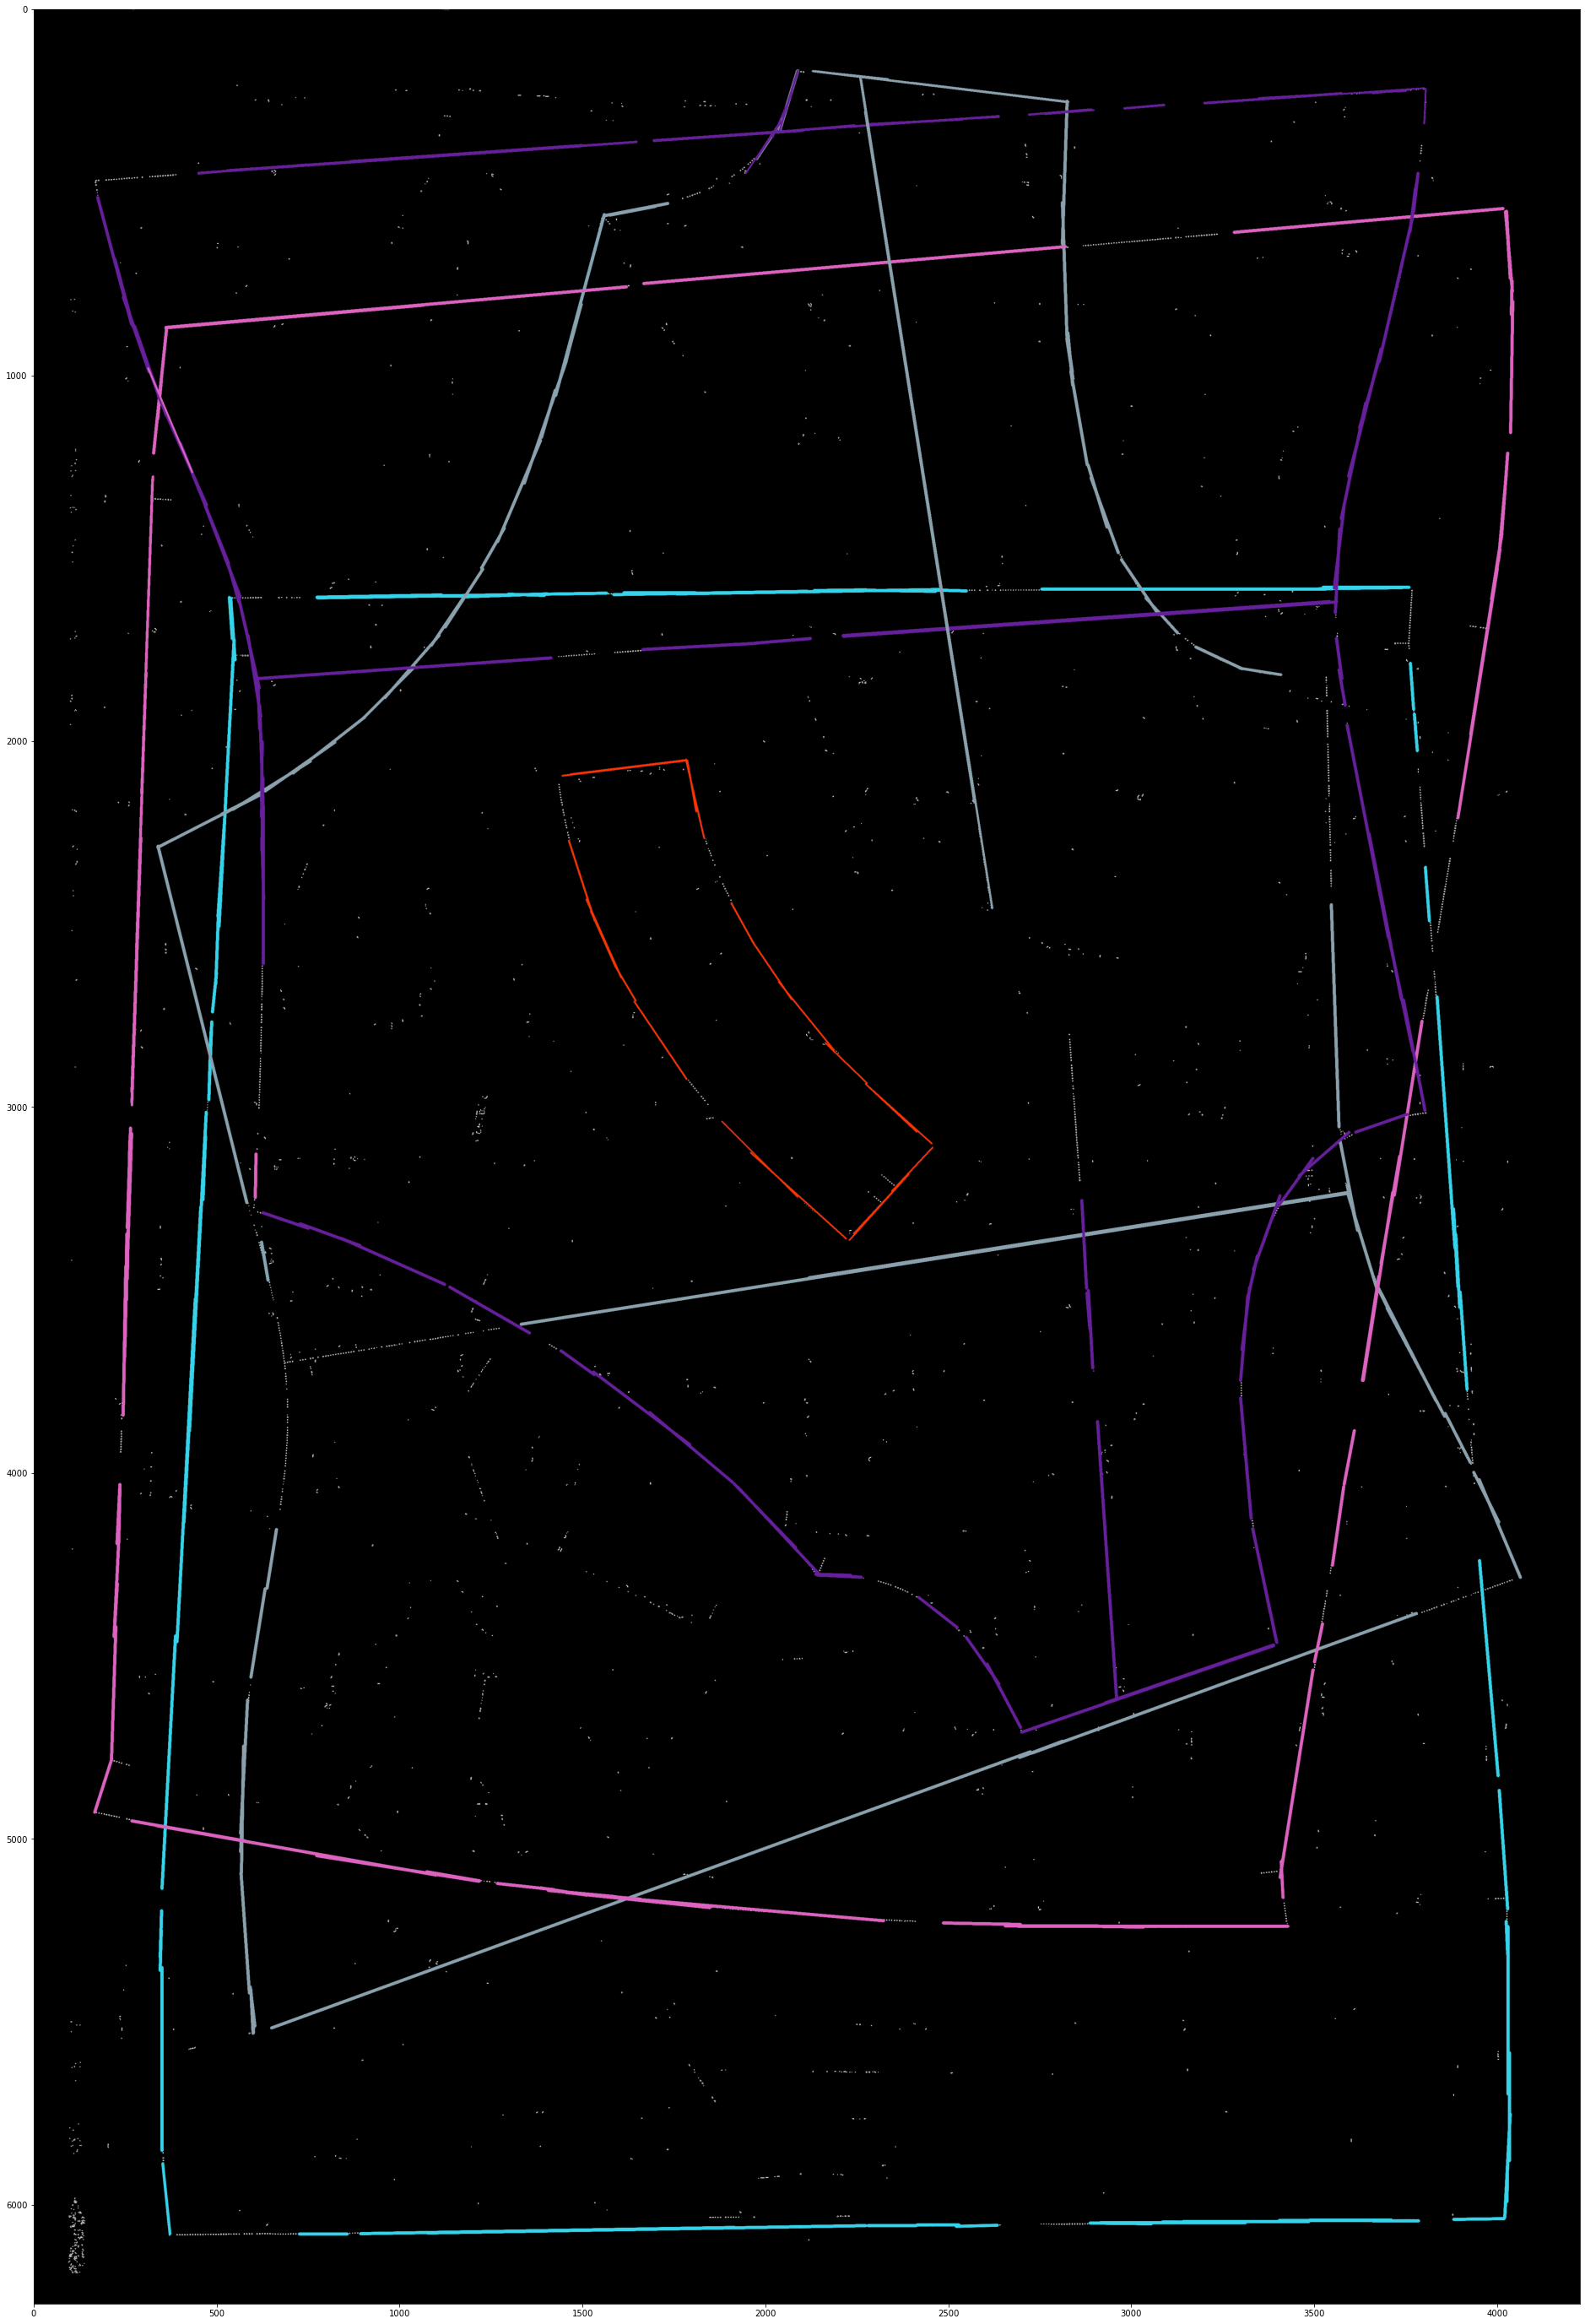

In [115]:
'''
def rgb(x):
    x = int(x)
    while (x > 255):
        x-=255
    return x

copy_lines = lines_detected.copy()

p4 = list()
for i in p5:
    if (i[2] in range(200,450)) and (i[3] in range(1200,3000)):
        p4.append(i)
'''
for k in p5:
    
    x1,y1,x2,y2 = k.reshape(4)

    #color = (rgb(3280),rgb(609),rgb(4016))
    
    #if (y2 - y1) >= 0.0001:
    # Draw the start point
    cv2.line(t,(x1,y1),(x2,y2),(255,50,0),4)
plot(t)

In [117]:
cv2.imwrite('final.png',t)

True